In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, LSTM, GRU, SimpleRNN, Dropout, Conv1D, MaxPool1D
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

In [4]:
NUM_EPOCHS = 10
WINDOW_SIZE = 12
BATCH_SIZE = 32
EPOCHS = 500
FOLDER_PATH = "./drive/MyDrive/ColabData/IS-2/"

# Loading data

In [5]:
climate_dataset = pd.concat([pd.read_csv(FOLDER_PATH + "data/DailyDelhiClimateTrain.csv"), pd.read_csv(FOLDER_PATH + "data/DailyDelhiClimateTest.csv")])

In [6]:
climate_dataset["date"] = pd.to_datetime(climate_dataset["date"])
climate_dataset.sort_values(by="date")

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [7]:
temp_data = climate_dataset[["date", "meantemp"]]

In [8]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1576 entries, 0 to 113
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1576 non-null   datetime64[ns]
 1   meantemp  1576 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 36.9 KB


# Visualizing data

In [9]:
temp_data.describe().style.background_gradient(cmap = 'Oranges')

,meantemp
count,1576.000000
mean,25.221918
std,7.345014
min,6.000000
25%,18.500000
50%,27.166667
75%,31.142857
max,38.714286


Text(0, 0.5, 'Temperature')

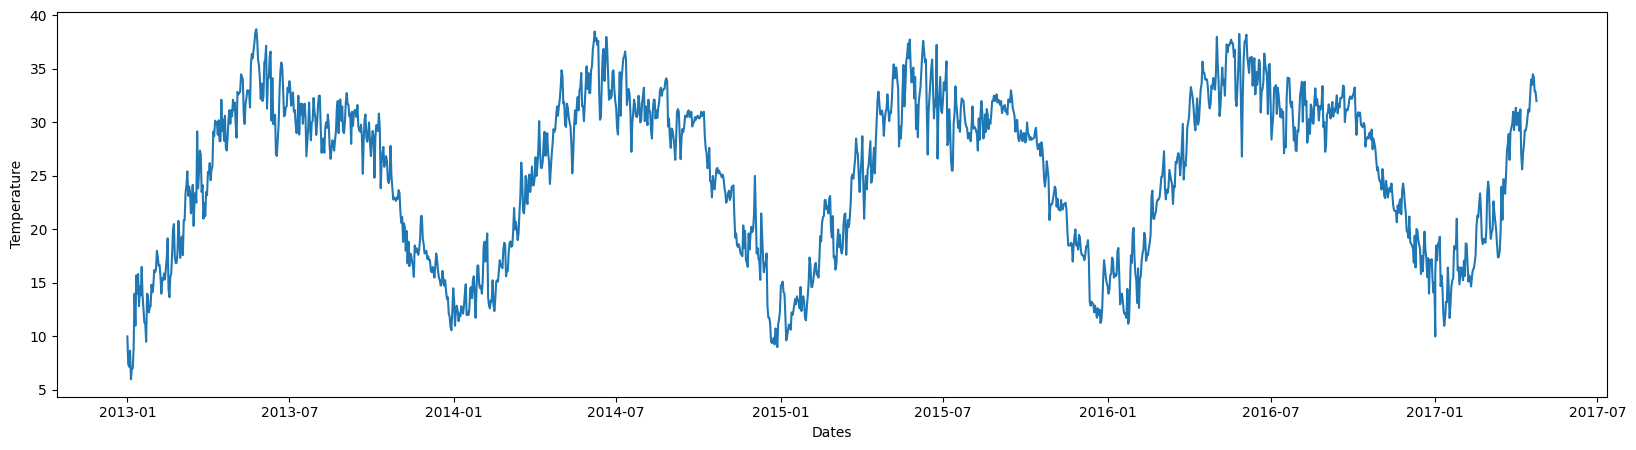

In [10]:
fig = plt.figure(figsize=(20, 5))
plt.plot(temp_data["date"], temp_data["meantemp"])
plt.xlabel("Dates")
plt.ylabel("Temperature")

# Splitting data and creating windows for training

In [11]:
def split_dataframe(dataframe, split):
    train, test = np.split(temp_data, [int(split*len(dataframe))])
    return train, test

In [12]:
def create_windows(dataframe, window):
    df = dataframe.values
    values, labels = [], []
    for i in range(window, len(df)):
        values.append(df[i-window:i])
        labels.append(df[i])
    values, labels = np.array(values), np.array(labels)
    values=np.reshape(values,(values.shape[0],values.shape[1],1))
    return values, labels


In [13]:
train_data, test_data = split_dataframe(temp_data, 0.25)

In [14]:
x_train, y_train = create_windows(train_data["meantemp"], WINDOW_SIZE)

Text(0, 0.5, 'Temperature')

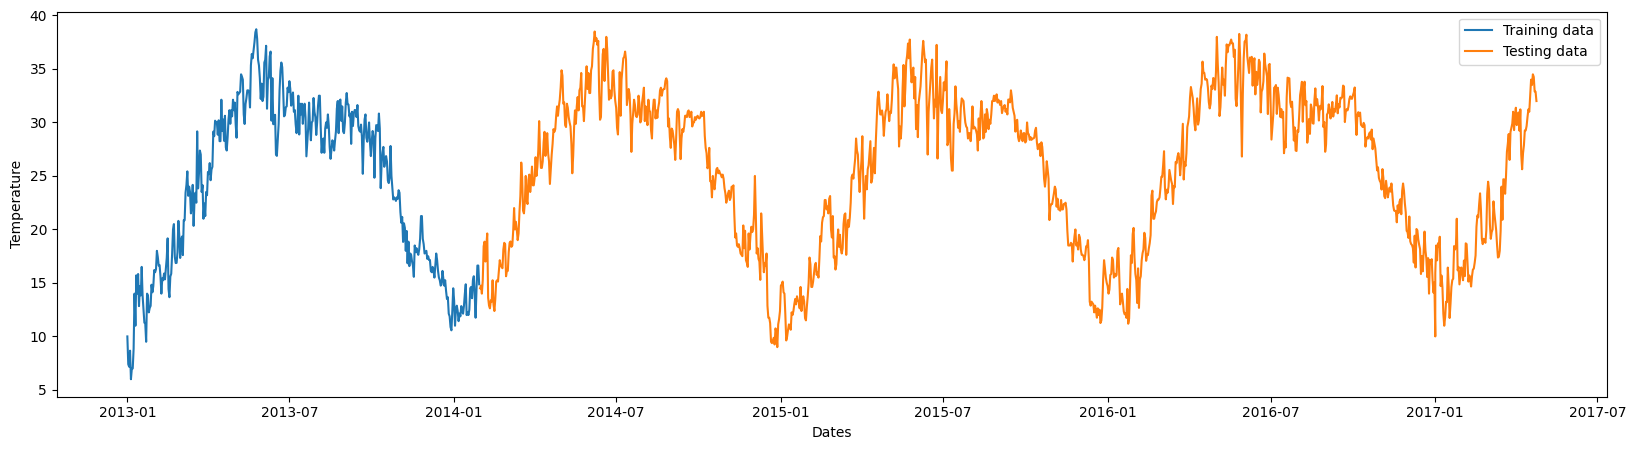

In [15]:
fig = plt.figure(figsize=(20, 5))
plt.plot(train_data["date"], train_data["meantemp"])
plt.plot(test_data["date"], test_data["meantemp"])
plt.legend(["Training data", "Testing data"])
plt.xlabel("Dates")
plt.ylabel("Temperature")

In [16]:
x_test, y_test = create_windows(test_data["meantemp"], WINDOW_SIZE)

#Training simple models

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
def plot_results(loss, y_true, y_pred):
    fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[1, 3])
    fig.set_figheight(5)
    fig.set_figwidth(20)
    ax1.plot(loss, label='loss')
    ax1.set_title('Loss curve')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    ax2.plot(test_data["date"][12:], y_true, label='Real temperature')
    ax2.plot(test_data["date"][12:], y_pred, label='Predicted temperature')
    ax2.set(xlabel='Date', ylabel='Temperature')
    ax2.legend()
    fig.tight_layout()

In [19]:
def get_metrics(y_true, y_pred):
    return {"RMSE": mean_squared_error(y_true, y_pred, squared=False), 
            "MAE": mean_absolute_error(y_true, y_pred),
            "MAPE:": mean_absolute_percentage_error(y_true, y_pred)}

## SimpleRNN

In [20]:
class SimpleRNNModel(KerasRegressor):
    def __init__(
        self,
        amount_of_neurons=10,
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=100,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.amount_of_neurons = amount_of_neurons
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = Sequential([
            SimpleRNN(self.amount_of_neurons, input_shape=(12,1,)),
            Dense(1),
        ])
        model.compile(loss="mse", optimizer=compile_kwargs["optimizer"])
        return model

In [21]:
params = {
    "epochs": [100, 500],
    "batch_size": [16, 32],
    "amount_of_neurons": [10, 20],
}
simple_gs = GridSearchCV(SimpleRNNModel(), params, refit=True, cv=3, scoring='explained_variance')

In [22]:
simple_gs.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=SimpleRNNModel(batch_size=None, build_fn=None, callbacks=None, loss=None, metrics=None, model=None, random_state=None, run_eagerly=False, shuffle=True, validation_batch_size=None, validation_split=0.0, warm_start=False),
             param_grid={'amount_of_neurons': [10, 20], 'batch_size': [16, 32],
                         'epochs': [100, 500]},
             scoring='explained_variance')

In [23]:
print(f"Best explained varaience: {simple_gs.best_score_:.3f}\nBest parameters:\n{simple_gs.best_params_}")

Best explained varaience: 0.754
Best parameters:
{'amount_of_neurons': 20, 'batch_size': 16, 'epochs': 500}


In [24]:
simple_y_pred = simple_gs.predict(x_test)

In [25]:
simple_mertics = get_metrics(y_test, simple_y_pred)
simple_mertics

{'RMSE': 1.7371701722507815,
 'MAE': 1.3410909263812196,
 'MAPE:': 5.699404921988882}

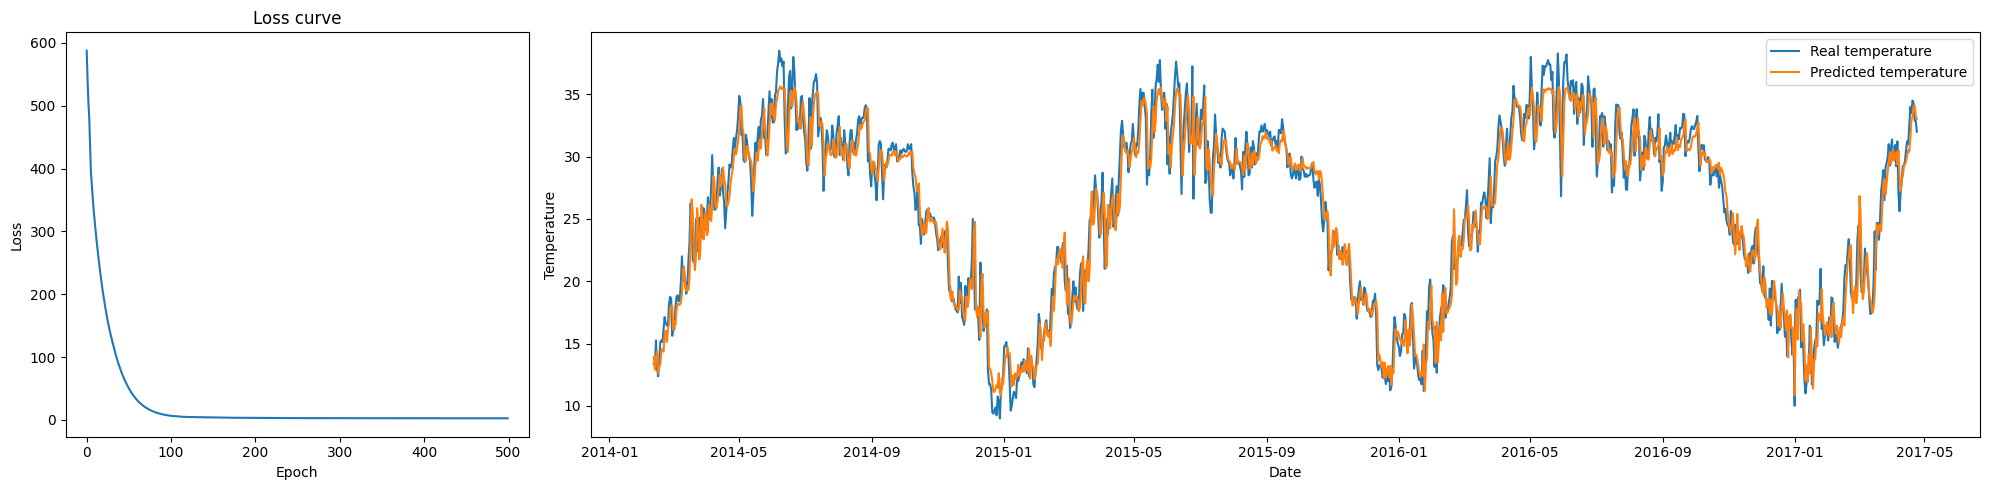

In [26]:
plot_results(simple_gs.best_estimator_.history_["loss"], y_test, simple_y_pred)

## LSTM

In [27]:
class SimpleLSTMModel(KerasRegressor):
    def __init__(
        self,
        amount_of_neurons=10,
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=100,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.amount_of_neurons = amount_of_neurons
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = Sequential([
            LSTM(self.amount_of_neurons, input_shape=(12,1,)),
            Dense(1),
        ])
        model.compile(loss="mse", optimizer=compile_kwargs["optimizer"])
        return model

In [28]:
params = {
    "epochs": [100, 500],
    "batch_size": [16, 32],
    "amount_of_neurons": [10, 20],
}
lstm_gs = GridSearchCV(SimpleLSTMModel(), params, refit=True, cv=3, scoring='explained_variance')

In [29]:
lstm_gs.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=SimpleLSTMModel(batch_size=None, build_fn=None, callbacks=None, loss=None, metrics=None, model=None, random_state=None, run_eagerly=False, shuffle=True, validation_batch_size=None, validation_split=0.0, warm_start=False),
             param_grid={'amount_of_neurons': [10, 20], 'batch_size': [16, 32],
                         'epochs': [100, 500]},
             scoring='explained_variance')

In [30]:
print(f"Best explained varaience: {lstm_gs.best_score_:.3f}\nBest parameters:\n{lstm_gs.best_params_}")

Best explained varaience: 0.753
Best parameters:
{'amount_of_neurons': 10, 'batch_size': 16, 'epochs': 500}


In [31]:
lstm_y_pred = lstm_gs.predict(x_test)

In [32]:
lstm_mertics = get_metrics(y_test, lstm_y_pred)
lstm_mertics

{'RMSE': 1.6446477876936585,
 'MAE': 1.2762102985379968,
 'MAPE:': 5.415620121586268}

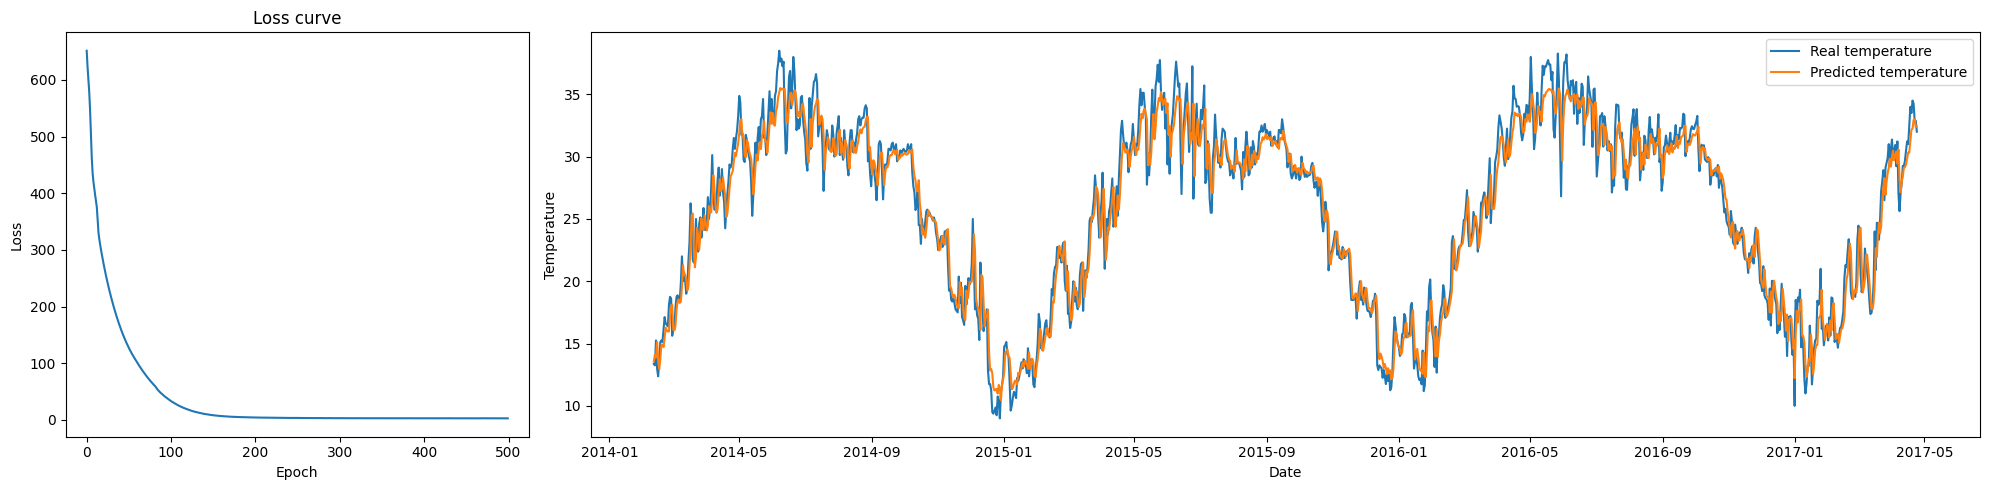

In [33]:
plot_results(lstm_gs.best_estimator_.history_["loss"], y_test, lstm_y_pred)

## GRU

In [34]:
class SimpleGRUModel(KerasRegressor):
    def __init__(
        self,
        amount_of_neurons=10,
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=100,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.amount_of_neurons = amount_of_neurons
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = Sequential([
            GRU(self.amount_of_neurons, input_shape=(12,1,)),
            Dense(1),
        ])
        model.compile(loss="mse", optimizer=compile_kwargs["optimizer"])
        return model

In [35]:
params = {
    "epochs": [100, 500],
    "batch_size": [16, 32],
    "amount_of_neurons": [10, 20],
}
gru_gs = GridSearchCV(SimpleGRUModel(), params, refit=True, cv=3, scoring='explained_variance')

In [36]:
gru_gs.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=SimpleGRUModel(batch_size=None, build_fn=None, callbacks=None, loss=None, metrics=None, model=None, random_state=None, run_eagerly=False, shuffle=True, validation_batch_size=None, validation_split=0.0, warm_start=False),
             param_grid={'amount_of_neurons': [10, 20], 'batch_size': [16, 32],
                         'epochs': [100, 500]},
             scoring='explained_variance')

In [37]:
print(f"Best explained varaience: {gru_gs.best_score_:.3f}\nBest parameters:\n{gru_gs.best_params_}")

Best explained varaience: 0.735
Best parameters:
{'amount_of_neurons': 20, 'batch_size': 16, 'epochs': 500}


In [38]:
gru_y_pred = gru_gs.predict(x_test)

In [39]:
gru_mertics = get_metrics(y_test, gru_y_pred)
gru_mertics

{'RMSE': 1.734769292488315,
 'MAE': 1.335516872037897,
 'MAPE:': 5.8570509386271254}

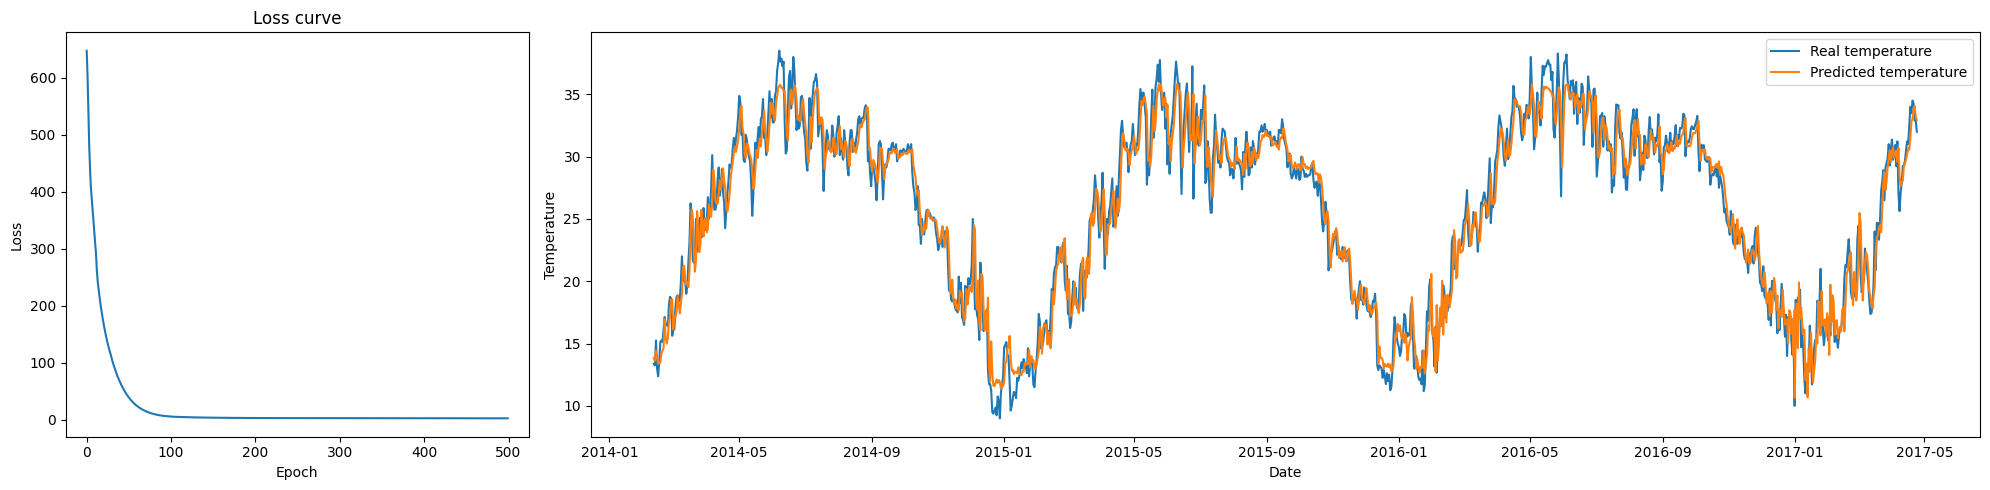

In [40]:
plot_results(gru_gs.best_estimator_.history_["loss"], y_test, gru_y_pred)

# Training deep models

In [88]:
def train_model(model, x_train, y_train, x_test, epochs=500, batch_size=16, verbose=0):
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    y_pred = model.predict(x_test)
    return y_pred, model.history_["loss"]

## Deep LSTM

In [89]:
class DeepLSTMModel(KerasRegressor):
    def __init__(
        self,
        amount_of_neurons=10,
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=100,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.amount_of_neurons = amount_of_neurons
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = Sequential([
            LSTM(self.amount_of_neurons, input_shape=(12,1,), return_sequences=True),
            LSTM(self.amount_of_neurons, return_sequences=True),
            LSTM(self.amount_of_neurons),
            Dense(1),
        ])
        model.compile(loss="mse", optimizer=compile_kwargs["optimizer"])
        return model

deepLSTM = DeepLSTMModel()

In [90]:
deep_lstm_y_pred, deep_lstm_loss = train_model(deepLSTM, x_train, y_train, x_test)

In [91]:
deep_lstm_metrics = get_metrics(y_test, deep_lstm_y_pred)
deep_lstm_metrics

{'RMSE': 1.6791739200502356,
 'MAE': 1.2973408081594717,
 'MAPE:': 5.519419204424375}

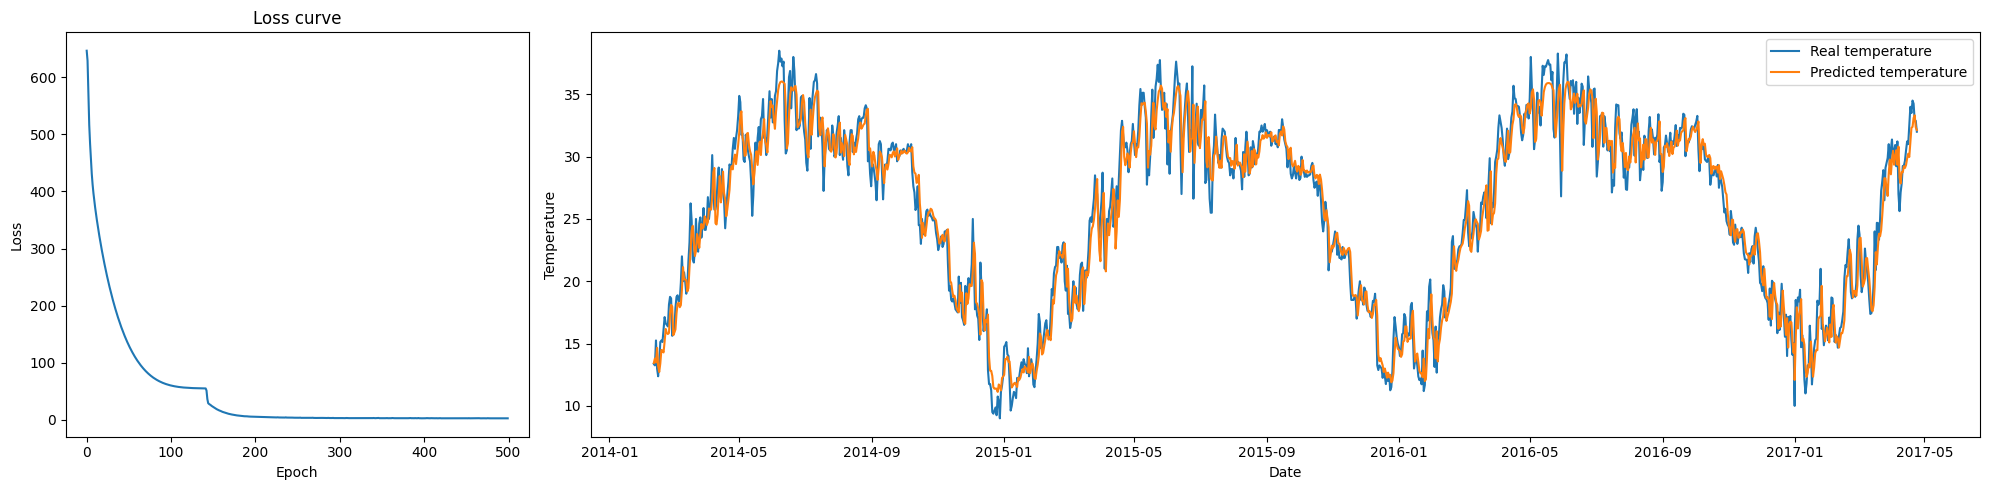

In [92]:
plot_results(deep_lstm_loss, y_test, deep_lstm_y_pred)

## Deep LSTM with Dropout

In [93]:
class DeepLSTMModelWithDropout(KerasRegressor):
    def __init__(
        self,
        amount_of_neurons=10,
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=100,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.amount_of_neurons = amount_of_neurons
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = Sequential([
            LSTM(self.amount_of_neurons, input_shape=(12,1,), return_sequences=True),
            Dropout(0.2),
            LSTM(self.amount_of_neurons, return_sequences=True),
            Dropout(0.2),
            LSTM(self.amount_of_neurons),
            Dense(1),
        ])
        model.compile(loss="mse", optimizer=compile_kwargs["optimizer"])
        return model

In [94]:
deepLSTMDropout = DeepLSTMModelWithDropout()

In [95]:
deep_lstm_dropout_y_pred, deep_lstm_dropour_loss = train_model(deepLSTMDropout, x_train, y_train, x_test)

In [96]:
deep_lstm_dropout_metrics = get_metrics(y_test, deep_lstm_dropout_y_pred)
deep_lstm_dropout_metrics

{'RMSE': 1.943074596208534,
 'MAE': 1.5427067184222854,
 'MAPE:': 6.499202058002885}

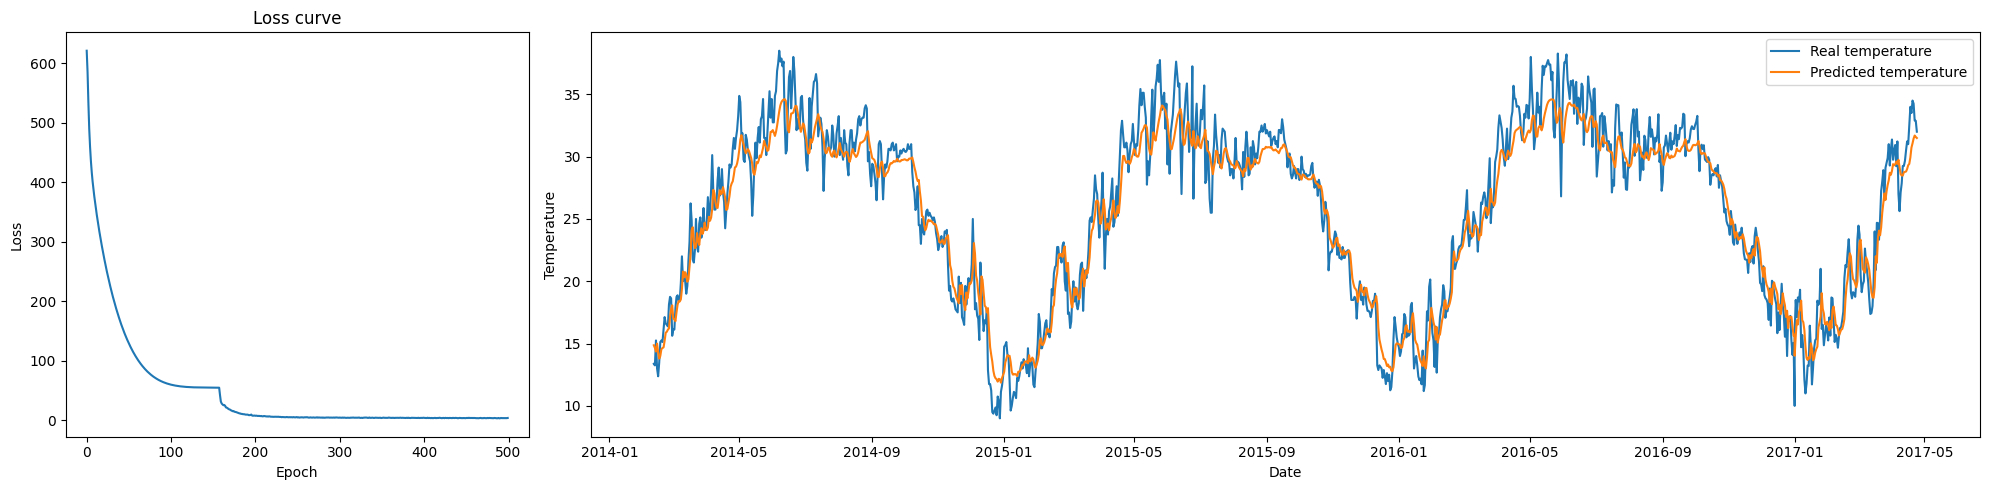

In [97]:
plot_results(deep_lstm_dropour_loss, y_test, deep_lstm_dropout_y_pred)

## Deep GRU

In [98]:
class DeepGRUModel(KerasRegressor):
    def __init__(
        self,
        amount_of_neurons=10,
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=100,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.amount_of_neurons = amount_of_neurons
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = Sequential([
            GRU(self.amount_of_neurons, input_shape=(12,1,), return_sequences=True),
            GRU(self.amount_of_neurons, return_sequences=True),
            GRU(self.amount_of_neurons),
            Dense(1),
        ])
        model.compile(loss="mse", optimizer=compile_kwargs["optimizer"])
        return model

In [99]:
deepGRU = DeepGRUModel()

In [100]:
deep_gru_y_pred, deep_gru_loss = train_model(deepGRU, x_train, y_train, x_test)

In [101]:
deep_gru_metrics = get_metrics(y_test, deep_lstm_dropout_y_pred)
deep_gru_metrics

{'RMSE': 1.943074596208534,
 'MAE': 1.5427067184222854,
 'MAPE:': 6.499202058002885}

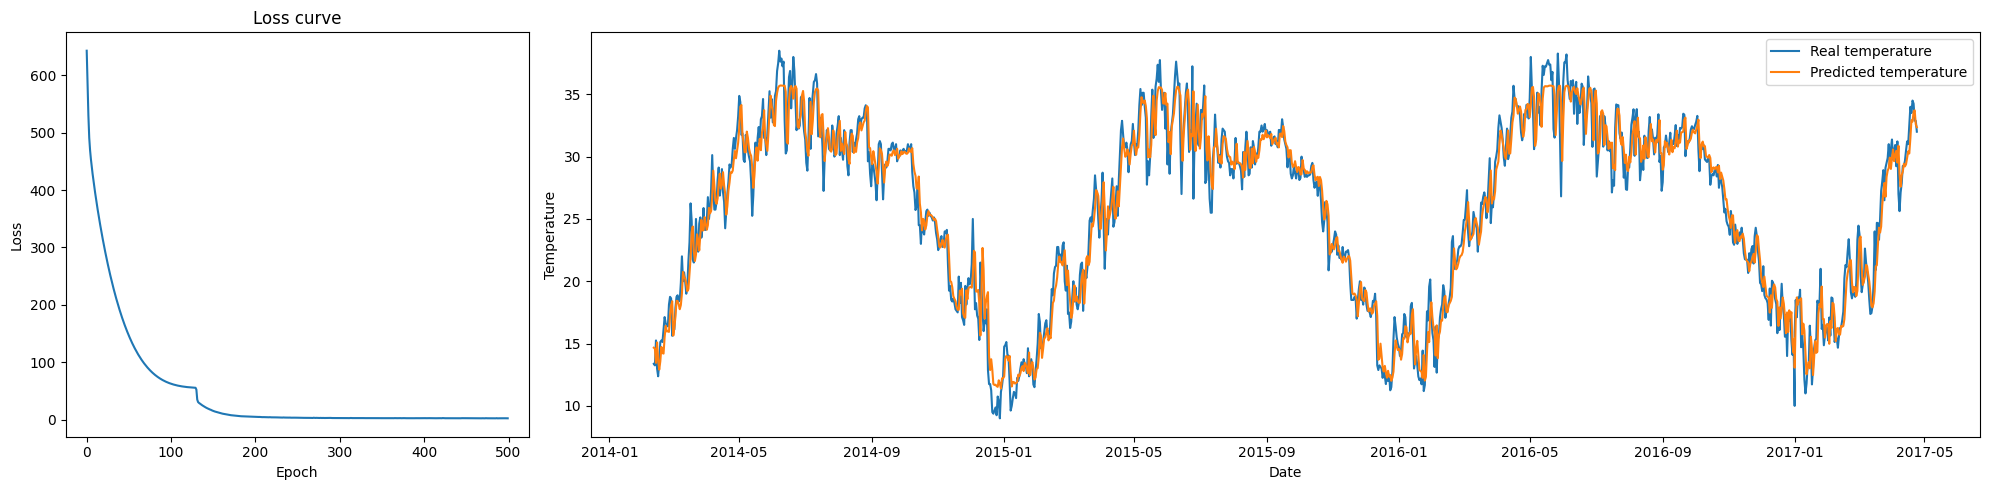

In [102]:
plot_results(deep_gru_loss, y_test, deep_gru_y_pred)

## Deep GRU with Dropout

In [103]:
class DeepGRUModelWithDropout(KerasRegressor):
    def __init__(
        self,
        amount_of_neurons=10,
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=100,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.amount_of_neurons = amount_of_neurons
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = Sequential([
            GRU(self.amount_of_neurons, input_shape=(12,1,), return_sequences=True),
            Dropout(0.2),
            GRU(self.amount_of_neurons, return_sequences=True),
            Dropout(0.2),
            GRU(self.amount_of_neurons),
            Dense(1),
        ])
        model.compile(loss="mse", optimizer=compile_kwargs["optimizer"])
        return model

In [104]:
deepGRUDropout = DeepGRUModelWithDropout()

In [105]:
deep_gru_dropout_y_pred, deep_gru_dropour_loss = train_model(deepGRUDropout, x_train, y_train, x_test)

In [106]:
deep_gru_dropout_metrics = get_metrics(y_test, deep_gru_dropout_y_pred)
deep_gru_dropout_metrics

{'RMSE': 1.8498490686754638,
 'MAE': 1.453627531721688,
 'MAPE:': 6.28688330031449}

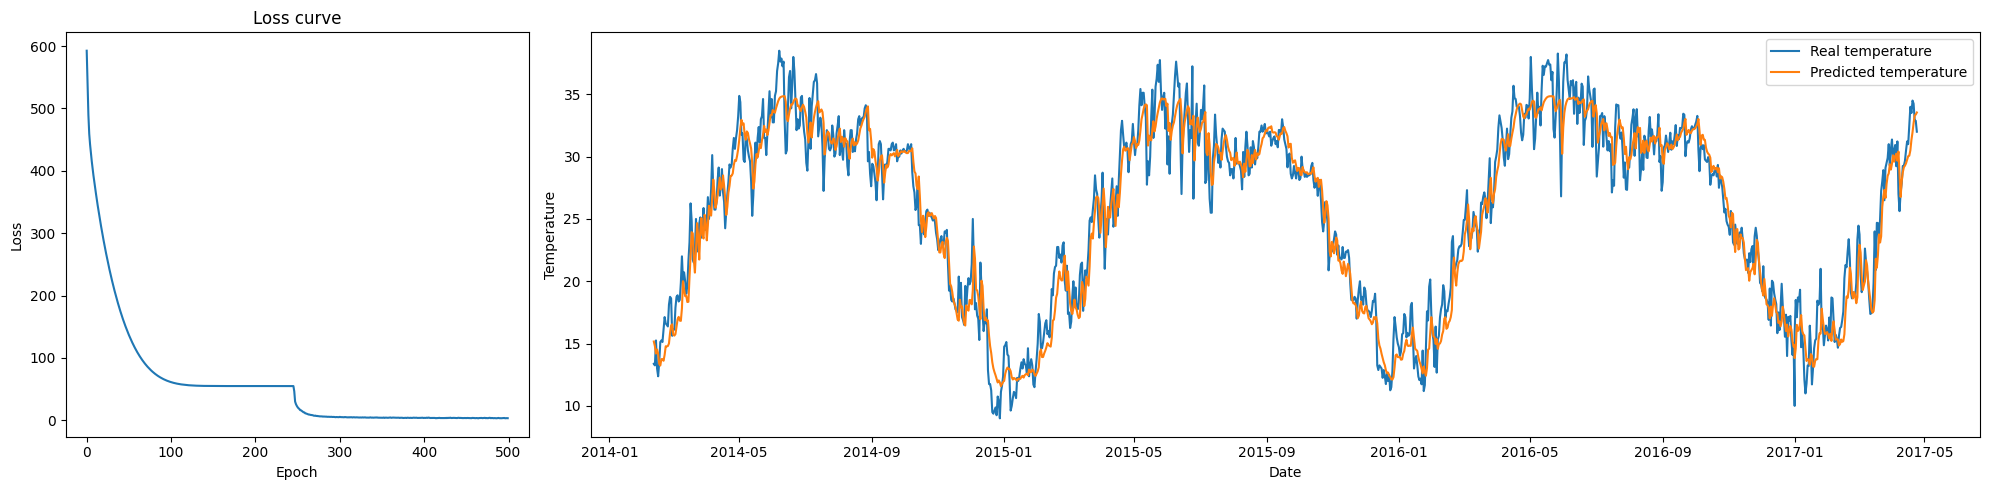

In [107]:
plot_results(deep_gru_dropour_loss, y_test, deep_gru_dropout_y_pred)

## Networks with Conv1D

In [120]:
class Conv1DModel(KerasRegressor):
    def __init__(
        self,
        optimizer="adam",
        optimizer__learning_rate=0.001,
        epochs=100,
        verbose=0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.optimizer = optimizer
        self.epochs = epochs
        self.verbose = verbose

    def _keras_build_fn(self, compile_kwargs):
        model = Sequential([
            Conv1D(32, 4, input_shape=(12,1,)),
            MaxPool1D(),
            Conv1D(64, 4),
            Flatten(),
            Dense(1),
        ])
        model.compile(loss="mse", optimizer=compile_kwargs["optimizer"])
        return model

In [121]:
conv1DModel = Conv1DModel()

In [122]:
conv_y_pred, conv_dropour_loss = train_model(conv1DModel, x_train, y_train, x_test, epochs=100)

In [123]:
conv_dropout_metrics = get_metrics(y_test, conv_y_pred)
conv_dropout_metrics

{'RMSE': 2.1273304190356095,
 'MAE': 1.651183643774916,
 'MAPE:': 7.235322342720223}

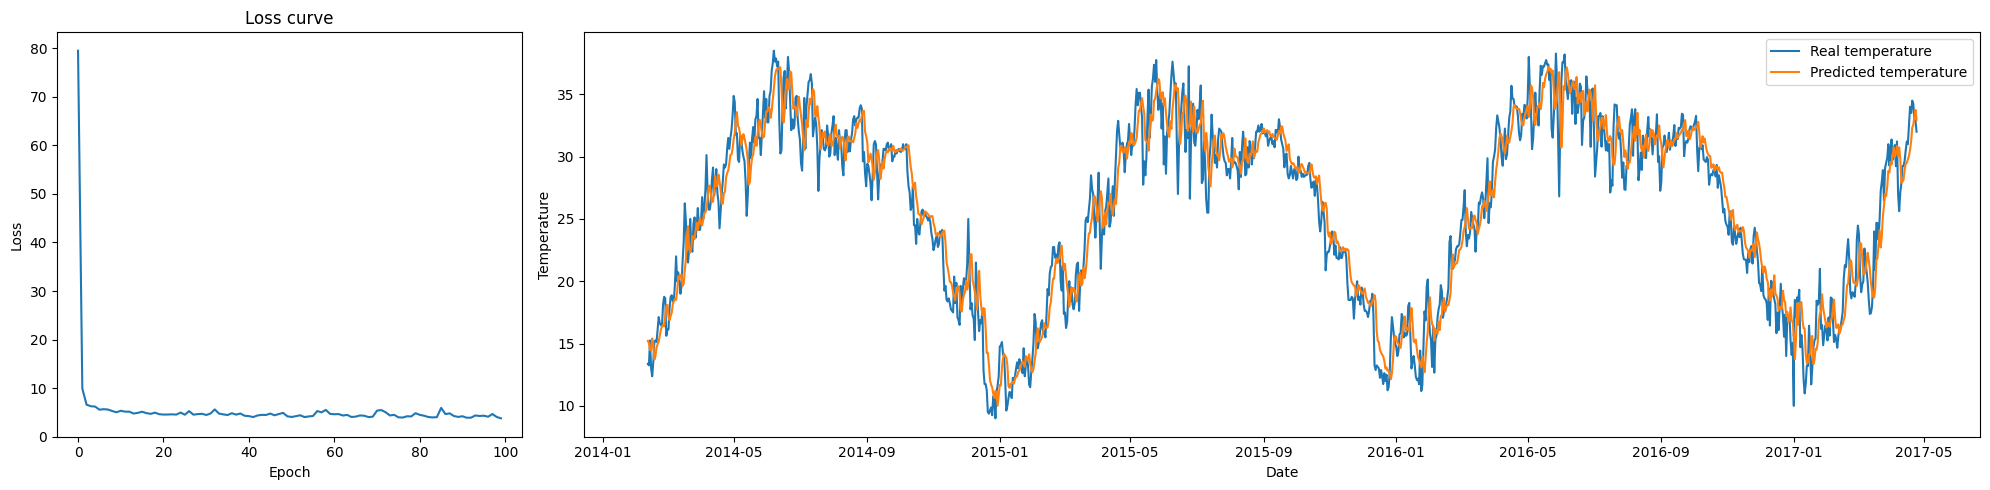

In [124]:
plot_results(conv_dropour_loss, y_test, conv_y_pred)

After the comparation of all models we can conclude that the one using Conv1D gave the best results as it reached decent accuracy with siginficantly smaller amount of epochs. Also it is better at reproducing behavior of the mean temperature time series.